In [1]:
%%prun
from numpy import *


def calc_jacobi_matrix(f, x, dx=1e-8):
    '''
    Матрица Якоби отображения f в точке x.
    Прозводная в матрице вычисляется конечной разностью вперед с шагом dx.

    f -- отображение,
    x -- вектор,
    dx -- точность производной.
    '''

    n, = x.shape
    x_plus_dx = empty(n)
    x_plus_dx[:] = x
    jacobi_matrix = empty((n, n))

    for j in range(n):
        x_plus_dx[:] = x
        x_plus_dx[j] += dx
        for i in range(n):
            jacobi_matrix[i, j] = (f(x_plus_dx, i) - f(x, i)) / dx        

    return jacobi_matrix


def newton_method(f, x0, eps=1e-8):
    '''
    Решение уравнения f(x) = 0 методом Ньютона.

    f -- отображение,
    x0 -- начальное приближение вектора x,
    eps -- точность решения.
    '''

    n, = x0.shape
    x = empty(n)
    x[:] = x0
    f_vector = empty(n)
    sigma = 1

    while linalg.norm(sigma) > eps:
        for i in range(n):
            f_vector[i] = f(x, i)
        jacobi_matrix = calc_jacobi_matrix(f, x)
        sigma = linalg.solve(jacobi_matrix, - f_vector)
        x += sigma
    
    return x


def a(s):
    return 1 / 1500 / (s + 1) / (s + 1)


def f(x, i):
    if i == 0: f = (x[i] - s[j][i + 1]) / tau + a(x[i]) * (x[i] - s[j + 1][i]) / h
    else:      f = (x[i] - s[j][i + 1]) / tau + a(x[i]) * (x[i] - x[i - 1]) / h

    return f


l = 10  # метры, 10 метров, область 0 < x < l
T = 4 * 60 * 60  # секунды, 4 часа, область 0 < t < T
n = 31  # кол-во точек в равномерной сетке по x
m = 31  # кол-во точек в равномерной сетке по t

s_boundary = 1  # левое граничное условие
s_initial = 0  # начальное условие

x = linspace(0, l, n)  # равномерная сетка по x с n точками
t = linspace(0, T, m)  # равномерная сетка по t с m точками
s = empty((m, n))  # значения водонасыщенности в сетке по x и t

h = x[1] - x[0]  # шаг по x
tau = t[1] - t[0]  # шаг по t

s[:, 0] = s_boundary  # левое граничное условие
s[0, 1:] = s_initial  # начальное условие

for j in range(0, m - 1):
    x0 = s[j, 1:]  # задаем начальное приближение слоя времени j + 1 как решение слоя времени j
    x_soltn = newton_method(f, x0)  # вычисляем слой времени j + 1 неизвестных величин
    s[j + 1, 1:] = x_soltn  # записываем решение

         430513 function calls (429113 primitive calls) in 2.602 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   186660    1.348    0.000    1.706    0.000 <string>:57(f)
      102    0.365    0.004    2.040    0.020 <string>:4(calc_jacobi_matrix)
   186660    0.357    0.000    0.357    0.000 <string>:53(a)
      102    0.218    0.002    0.224    0.002 linalg.py:306(solve)
      337    0.049    0.000    0.049    0.000 {built-in method posix.stat}
       82    0.039    0.000    0.039    0.000 {built-in method marshal.loads}
       13    0.024    0.002    0.024    0.002 {built-in method _imp.create_dynamic}
       30    0.010    0.000    2.315    0.077 <string>:28(newton_method)
     83/1    0.009    0.000    2.603    2.603 {built-in method builtins.exec}
       82    0.009    0.000    0.009    0.000 {built-in method io.open_code}
      314    0.008    0.000    0.027    0.000 overrides.py:170(decorator)
       82    0.008 

Сумма модулей отклонения: 6.554%


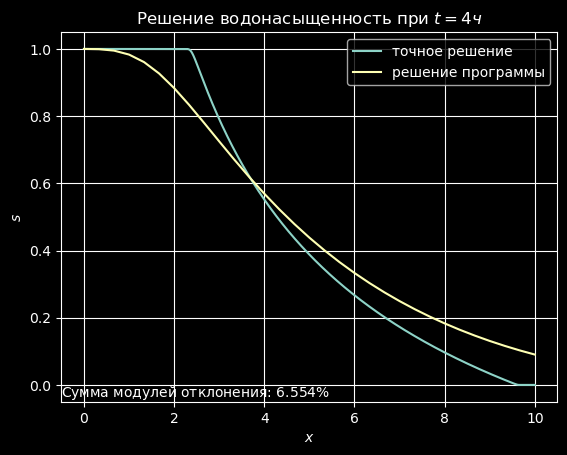

In [2]:
%matplotlib inline
from numpy import *
from scipy import interpolate
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# загрузить точное решение при t = 4
exact_x = load('exact_x.npy')
exact_s = load('exact_s.npy')

# численное решение
approx_x = x
approx_s = s[-1]  # s(x, t=4)

approx_s_func = interpolate.interp1d(approx_x, approx_s)

approx_s_in_exact_x = approx_s_func(exact_x)

n = exact_s.shape
error = sum(abs(approx_s_in_exact_x - exact_s)) / n

print('Сумма модулей отклонения: {:.4g}%'.format(float(error * 100)))

ax = plt.subplot()
plt.title('Решение водонасыщенность при $t = 4 ч$')
ax.text(0, 0,'Сумма модулей отклонения: ${:.4g}\%$'.format(float(error * 100)),
    ha='left', va='bottom', transform=ax.transAxes)
plt.plot(exact_x, exact_s, label='точное решение')
plt.plot(approx_x, approx_s, label='решение программы')
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$s$')
plt.legend();